# Random Forest Exercises

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

## Acquire

In [2]:
# Acquire Step
df = acquire.get_titanic_data()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [3]:
# prepare the data
df = prepare.prep_titanic_data(df)
df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0,3
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1,3
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0,3
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1,3


In [4]:
# impute age in simplistic manner

df.age = df.age.fillna(df.age.mean())

In [5]:
# drop columns not needed
df = df.drop(columns=['pclass', 'embarked', 'embarked_encode', 'passenger_id'])

In [6]:
# encode columns
df = pd.get_dummies(df, ['sex', 'class', 'embark_town'], drop_first=True)
df.head()

,survived,age,sibsp,parch,fare,alone,sex_male,class_Second,class_Third,embark_town_Queenstown,embark_town_Southampton
0,0,22.0,1,0,7.2500,0,1,0,1,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0,0
2,1,26.0,0,0,7.9250,1,0,0,1,0,1
3,1,35.0,1,0,53.1000,0,0,0,0,0,1
4,0,35.0,0,0,8.0500,1,1,0,1,0,1


In [7]:
# split the data
train, validate, test = prepare.split(df, stratify_by='survived')

In [8]:
X_train = train.drop(columns=["survived"])
y_train = train.survived

X_validate = validate.drop(columns=["survived"])
y_validate = validate.survived

X_test = test.drop(columns=["survived"])
y_test = test.survived

In [9]:
X_train.head()

,age,sibsp,parch,fare,alone,sex_male,class_Second,class_Third,embark_town_Queenstown,embark_town_Southampton
583,36.000000,0,0,40.1250,1,1,0,0,0,0
165,9.000000,0,2,20.5250,0,1,0,1,0,1
50,7.000000,4,1,39.6875,0,1,0,1,0,1
259,50.000000,0,1,26.0000,0,0,1,0,0,1
306,29.699118,0,0,110.8833,1,0,0,0,0,0


In [10]:
# check the shape
X_train.shape, X_validate.shape, X_test.shape

((498, 10), (214, 10), (179, 10))

In [11]:
# Explore you data to find features with preditive power against the target
# Summarize what found in exploration and list the features you want to model with

## Onto Modeling

In [12]:
#  mode for target?
y_train.value_counts()

0    307
1    191
Name: survived, dtype: int64

In [13]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline prediction: {baseline[0]}")
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline prediction: 0
Baseline accuracy: 0.62


In [14]:
# Make the model
forest1 = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of depth 3")
pd.DataFrame(report)

Tree of depth 3


,0,1,accuracy,macro avg,weighted avg
precision,0.826087,0.856209,0.835341,0.841148,0.837640
recall,0.928339,0.685864,0.835341,0.807101,0.835341
f1-score,0.874233,0.761628,0.835341,0.817931,0.831045
support,307.000000,191.000000,0.835341,498.000000,498.000000


In [15]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,285,60
1,22,131


In [16]:
# We decided that 1 is positive and 0 is negative
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(131, 285, 22, 60)

In [17]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.8353413654618473
True Positive Rate: 0.6858638743455497
False Positive Rate: 0.07166123778501629
True Negative Rate: 0.9283387622149837
False Negative Rate: 0.31413612565445026
Precision: 0.8562091503267973
Recall: 0.6858638743455497
F1 Score: 0.7616279069767442
Support (0): 191
Support (1): 307


## Let's get loopy!

In [18]:
# Let's 
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                    0           1  accuracy   macro avg  weighted avg
precision    0.818966    0.853333  0.829317    0.836149      0.832147
recall       0.928339    0.670157  0.829317    0.799248      0.829317
f1-score     0.870229    0.750733  0.829317    0.810481      0.824398
support    307.000000  191.000000  0.829317  498.000000    498.000000

Tree with max depth of 3
                    0           1  accuracy   macro avg  weighted avg
precision    0.826087    0.856209  0.835341    0.841148      0.837640
recall       0.928339    0.685864  0.835341    0.807101      0.835341
f1-score     0.874233    0.761628  0.835341    0.817931      0.831045
support    307.000000  191.000000  0.835341  498.000000    498.000000

Tree with max depth of 4
                    0           1  accuracy   macro avg  weighted avg
precision    0.837209    0.876623  0.849398    0.856916      0.852326
recall       0.938111    0.706806  0.849398    0.822459      0.849398
f1-score     

## As we might expect
- The more depth to the tree, the more the model fits to the training data
- But we need to expect more to the story!
- How well the model works on data it hasn't seen before?

In [19]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.829317,0.780374,0.048943
1,3,0.835341,0.780374,0.054968
2,4,0.849398,0.813084,0.036313
3,5,0.857430,0.813084,0.044346
4,6,0.887550,0.813084,0.074466
5,7,0.913655,0.813084,0.100571
6,8,0.943775,0.813084,0.130691
7,9,0.963855,0.813084,0.150771
8,10,0.971888,0.817757,0.154131
9,11,0.977912,0.794393,0.183519


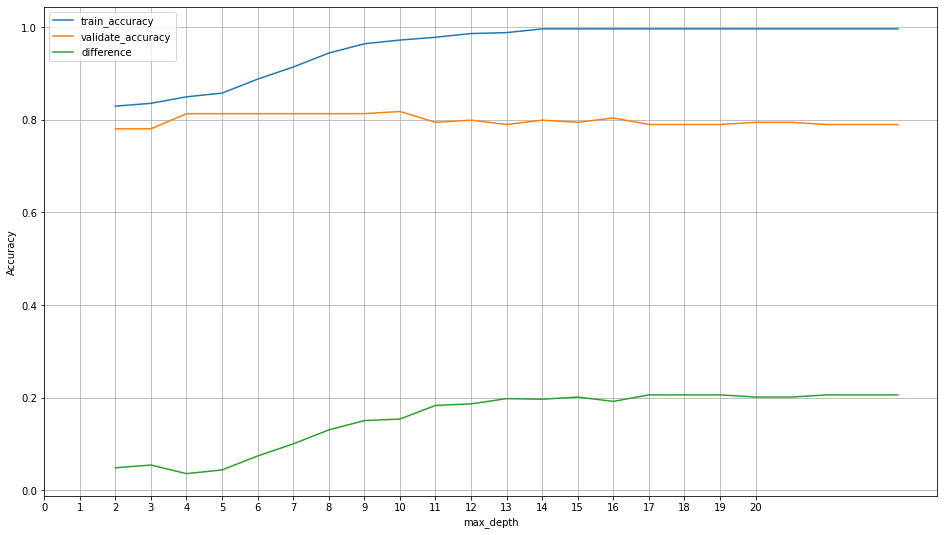

In [20]:
df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

## Increasing `min_samples_per_leaf`, decreasing `max_depth`

In [21]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = max_depth - i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,18,0.919679,0.813084,0.106595
1,3,17,0.901606,0.817757,0.083849
2,4,16,0.895582,0.822430,0.073152
3,5,15,0.875502,0.794393,0.081109
4,6,14,0.865462,0.794393,0.071069
5,7,13,0.863454,0.789720,0.073734
6,8,12,0.861446,0.794393,0.067053
7,9,11,0.863454,0.794393,0.069061
8,10,10,0.855422,0.785047,0.070375
9,11,9,0.839357,0.780374,0.058984


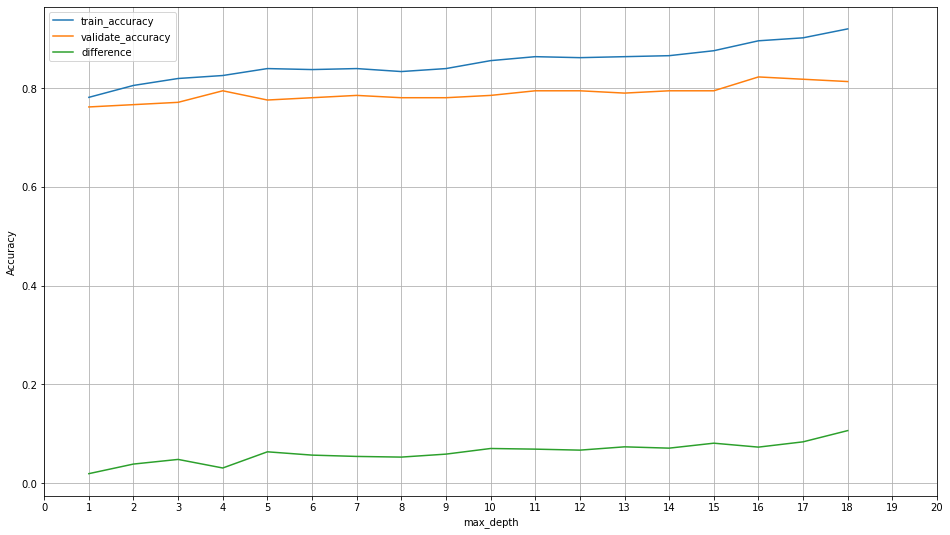

In [22]:
df.set_index('max_depth')[['train_accuracy', 'validate_accuracy','difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

## What if we increase both `min_samples_per_leaf` and `max_depth`

In [23]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 20

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.829317,0.780374,0.048943
1,3,3,0.833333,0.780374,0.052960
2,4,4,0.847390,0.808411,0.038978
3,5,5,0.857430,0.794393,0.063037
4,6,6,0.861446,0.794393,0.067053
5,7,7,0.857430,0.794393,0.063037
6,8,8,0.861446,0.789720,0.071726
7,9,9,0.863454,0.789720,0.073734
8,10,10,0.855422,0.785047,0.070375
9,11,11,0.839357,0.780374,0.058984


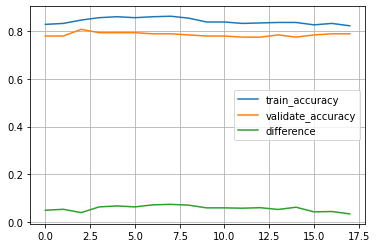

In [24]:
df[['train_accuracy', 'validate_accuracy','difference']].plot()
plt.grid()

## What about a fixed depth and increasing `min_samples_leaf`

In [25]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []


for i in range(2, 50):
    # Make the model
    depth = 6
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,6,0.871486,0.803738,0.067748
1,3,6,0.871486,0.808411,0.063075
2,4,6,0.861446,0.803738,0.057707
3,5,6,0.863454,0.799065,0.064388
4,6,6,0.861446,0.794393,0.067053
5,7,6,0.855422,0.794393,0.061029
6,8,6,0.855422,0.794393,0.061029
7,9,6,0.847390,0.789720,0.057670
8,10,6,0.847390,0.785047,0.062343
9,11,6,0.843373,0.789720,0.053654


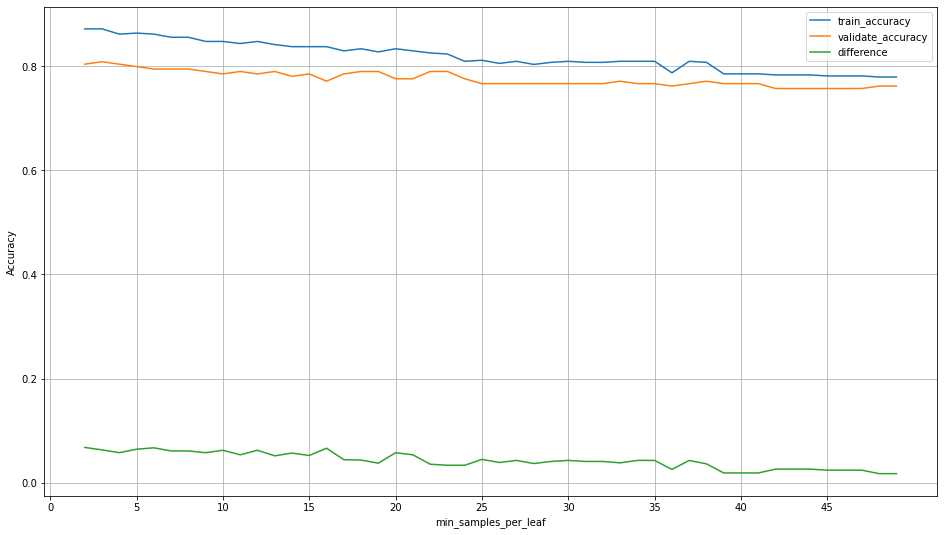

In [26]:
df.set_index('min_samples_per_leaf')[['train_accuracy', 'validate_accuracy', 'difference']].plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,50,5))
plt.grid()